#  CardioRisk Baseline

This notebook builds a simple cardiovascular risk prediction model using the Framingham dataset.

In [6]:
!pip install pandas xgboost optuna shap matplotlib seaborn scikit-learn

In [7]:
#  Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import shap


c:\Users\tranv\OneDrive\Documents\1nhuman118\git\cardiorisk_2505\notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:

#  Load and inspect the dataset
df = pd.read_csv("../data/framingham.csv")
print(df.shape)
df.head()


(4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [9]:

#  Drop rows with missing values (basic cleanup)
df = df.dropna()
print(df.shape)


(3658, 16)


##  Exploratory Data Analysis

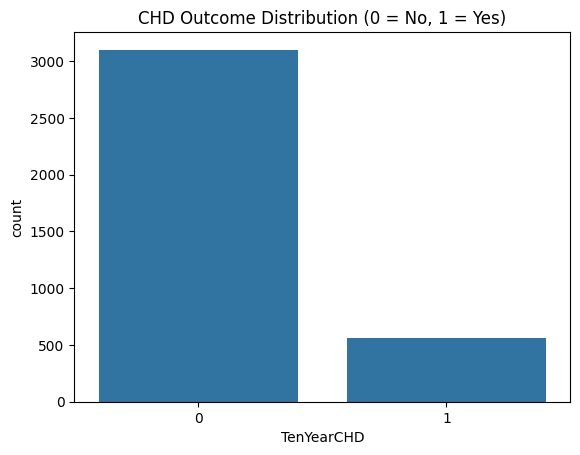

In [10]:

# Target class distribution
sns.countplot(x='TenYearCHD', data=df)
plt.title("CHD Outcome Distribution (0 = No, 1 = Yes)")
plt.show()


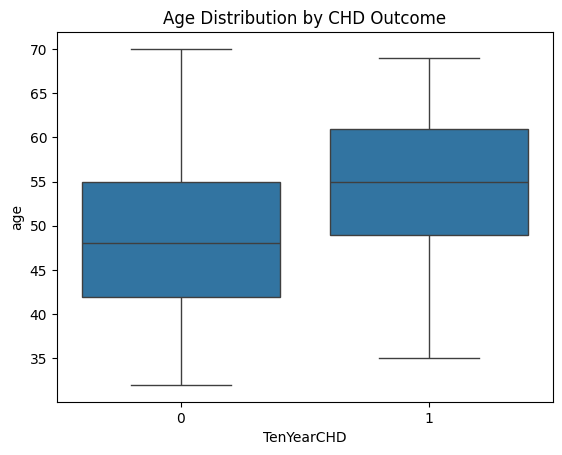

In [11]:

# Age distribution across CHD status
sns.boxplot(x='TenYearCHD', y='age', data=df)
plt.title("Age Distribution by CHD Outcome")
plt.show()


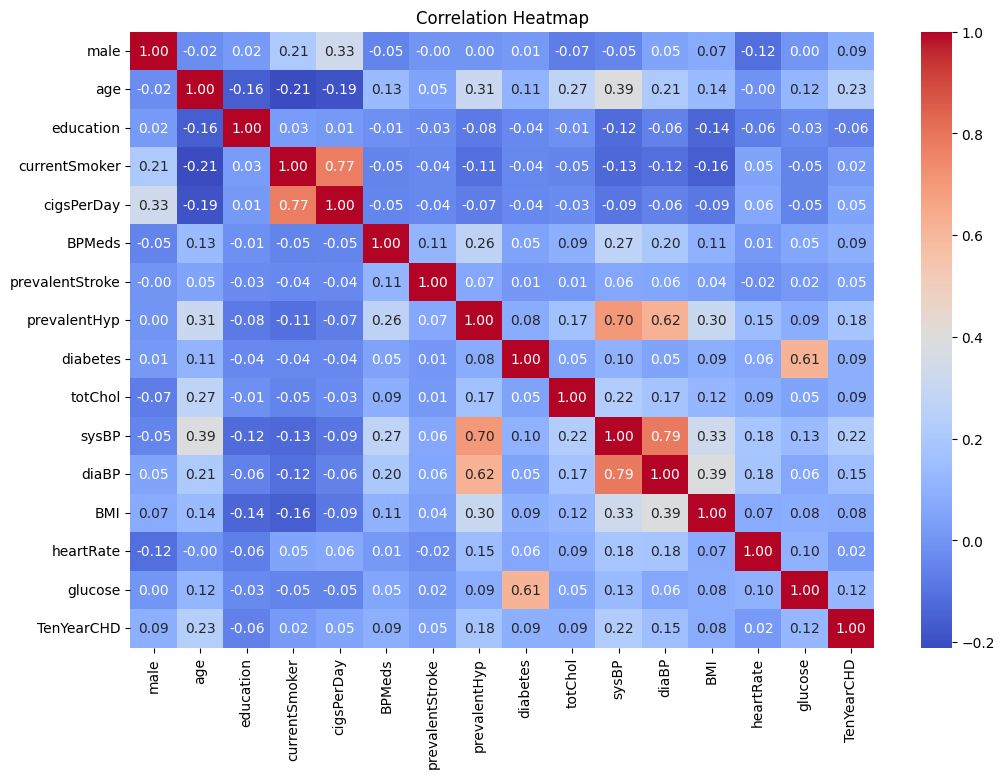

In [12]:

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


##  Model Training and Evaluation

In [13]:

# Prepare feature matrix X and target vector y
X = df.drop("TenYearCHD", axis=1)
y = df["TenYearCHD"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [14]:

# Initialize and train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='auc')
model.fit(X_train, y_train)


c:\Users\tranv\OneDrive\Documents\1nhuman118\git\cardiorisk_2505\notebooks\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:27:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [15]:

# Predict probabilities and calculate AUC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")


AUC Score: 0.6528


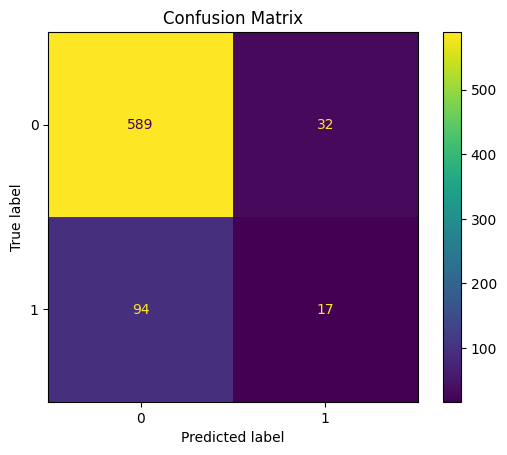

In [16]:

# Confusion matrix using default threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()


##  Model Explainability with SHAP

In [17]:

# Initialize SHAP explainer and calculate values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)


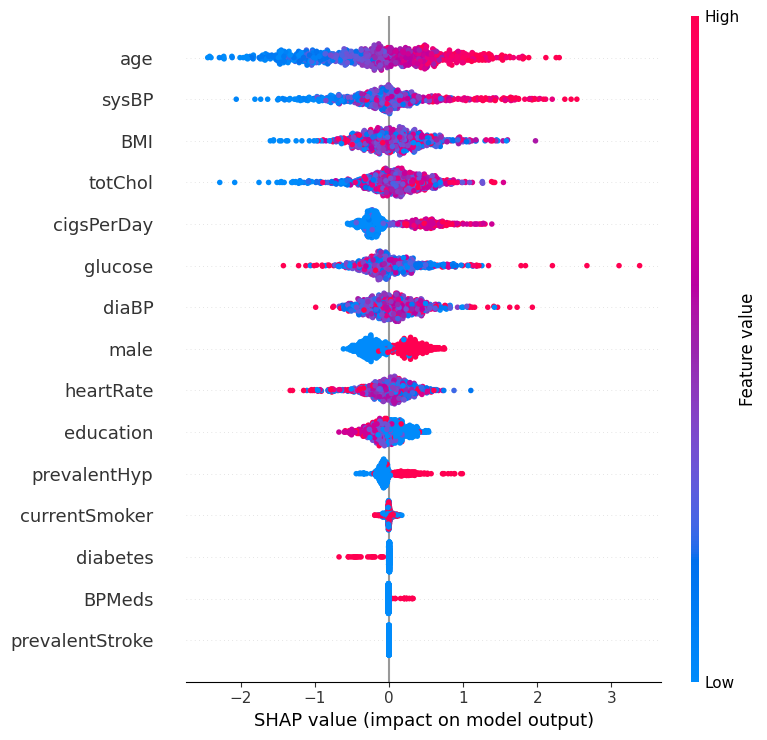

In [18]:

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test)


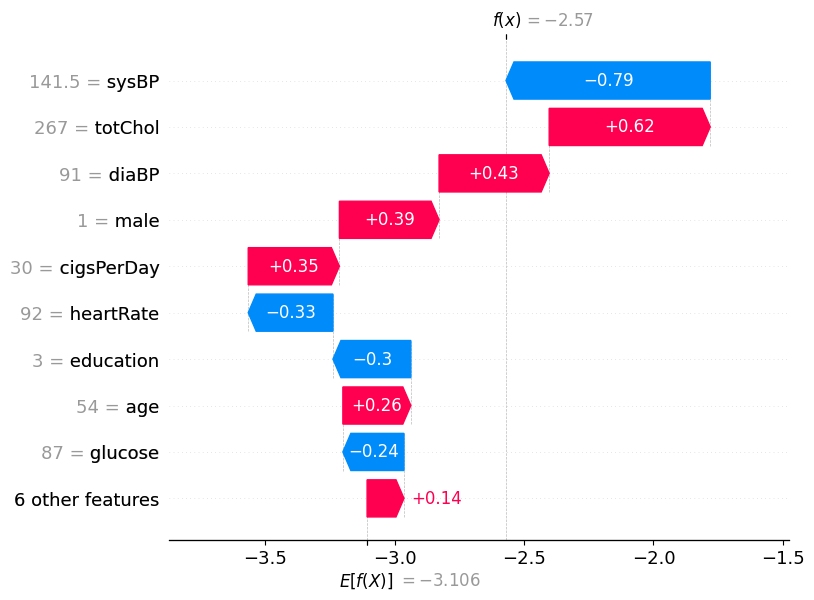

In [19]:

# Waterfall plot for the first prediction
shap.plots.waterfall(shap_values[0])
